In [1]:
import pdfplumber # Go to https://github.com/jsvine/pdfplumber for installation instructions and explanation
import numpy
import pandas
import os

In [2]:
path = r'../floor plans/'
fps = os.listdir(path)

#file_dir = r'floorplan.pdf' 
# Change to the location of the pdf file in your directory

full = pdfplumber.open(path +fps[1]).pages[0]

In [3]:
print(len(full.curves))
print(len(full.lines))
full.curves[0]

9325
5998


{'bottom': Decimal('333.680'),
 'doctop': Decimal('327.800'),
 'evenodd': False,
 'fill': False,
 'height': Decimal('5.880'),
 'linewidth': Decimal('6'),
 'non_stroking_color': (0, 0, 0),
 'object_type': 'curve',
 'page_number': 1,
 'points': [(Decimal('2002.720'), Decimal('333.680')),
  (Decimal('1993.000'), Decimal('333.680')),
  (Decimal('1993.000'), Decimal('327.800'))],
 'pts': [(Decimal('2002.720'), Decimal('1350.320')),
  (Decimal('1993.000'), Decimal('1350.320')),
  (Decimal('1993.000'), Decimal('1356.200'))],
 'stroke': True,
 'stroking_color': (0, 0, 0),
 'top': Decimal('327.800'),
 'width': Decimal('9.720'),
 'x0': Decimal('1993.000'),
 'x1': Decimal('2002.720'),
 'y0': Decimal('1350.320'),
 'y1': Decimal('1356.200')}

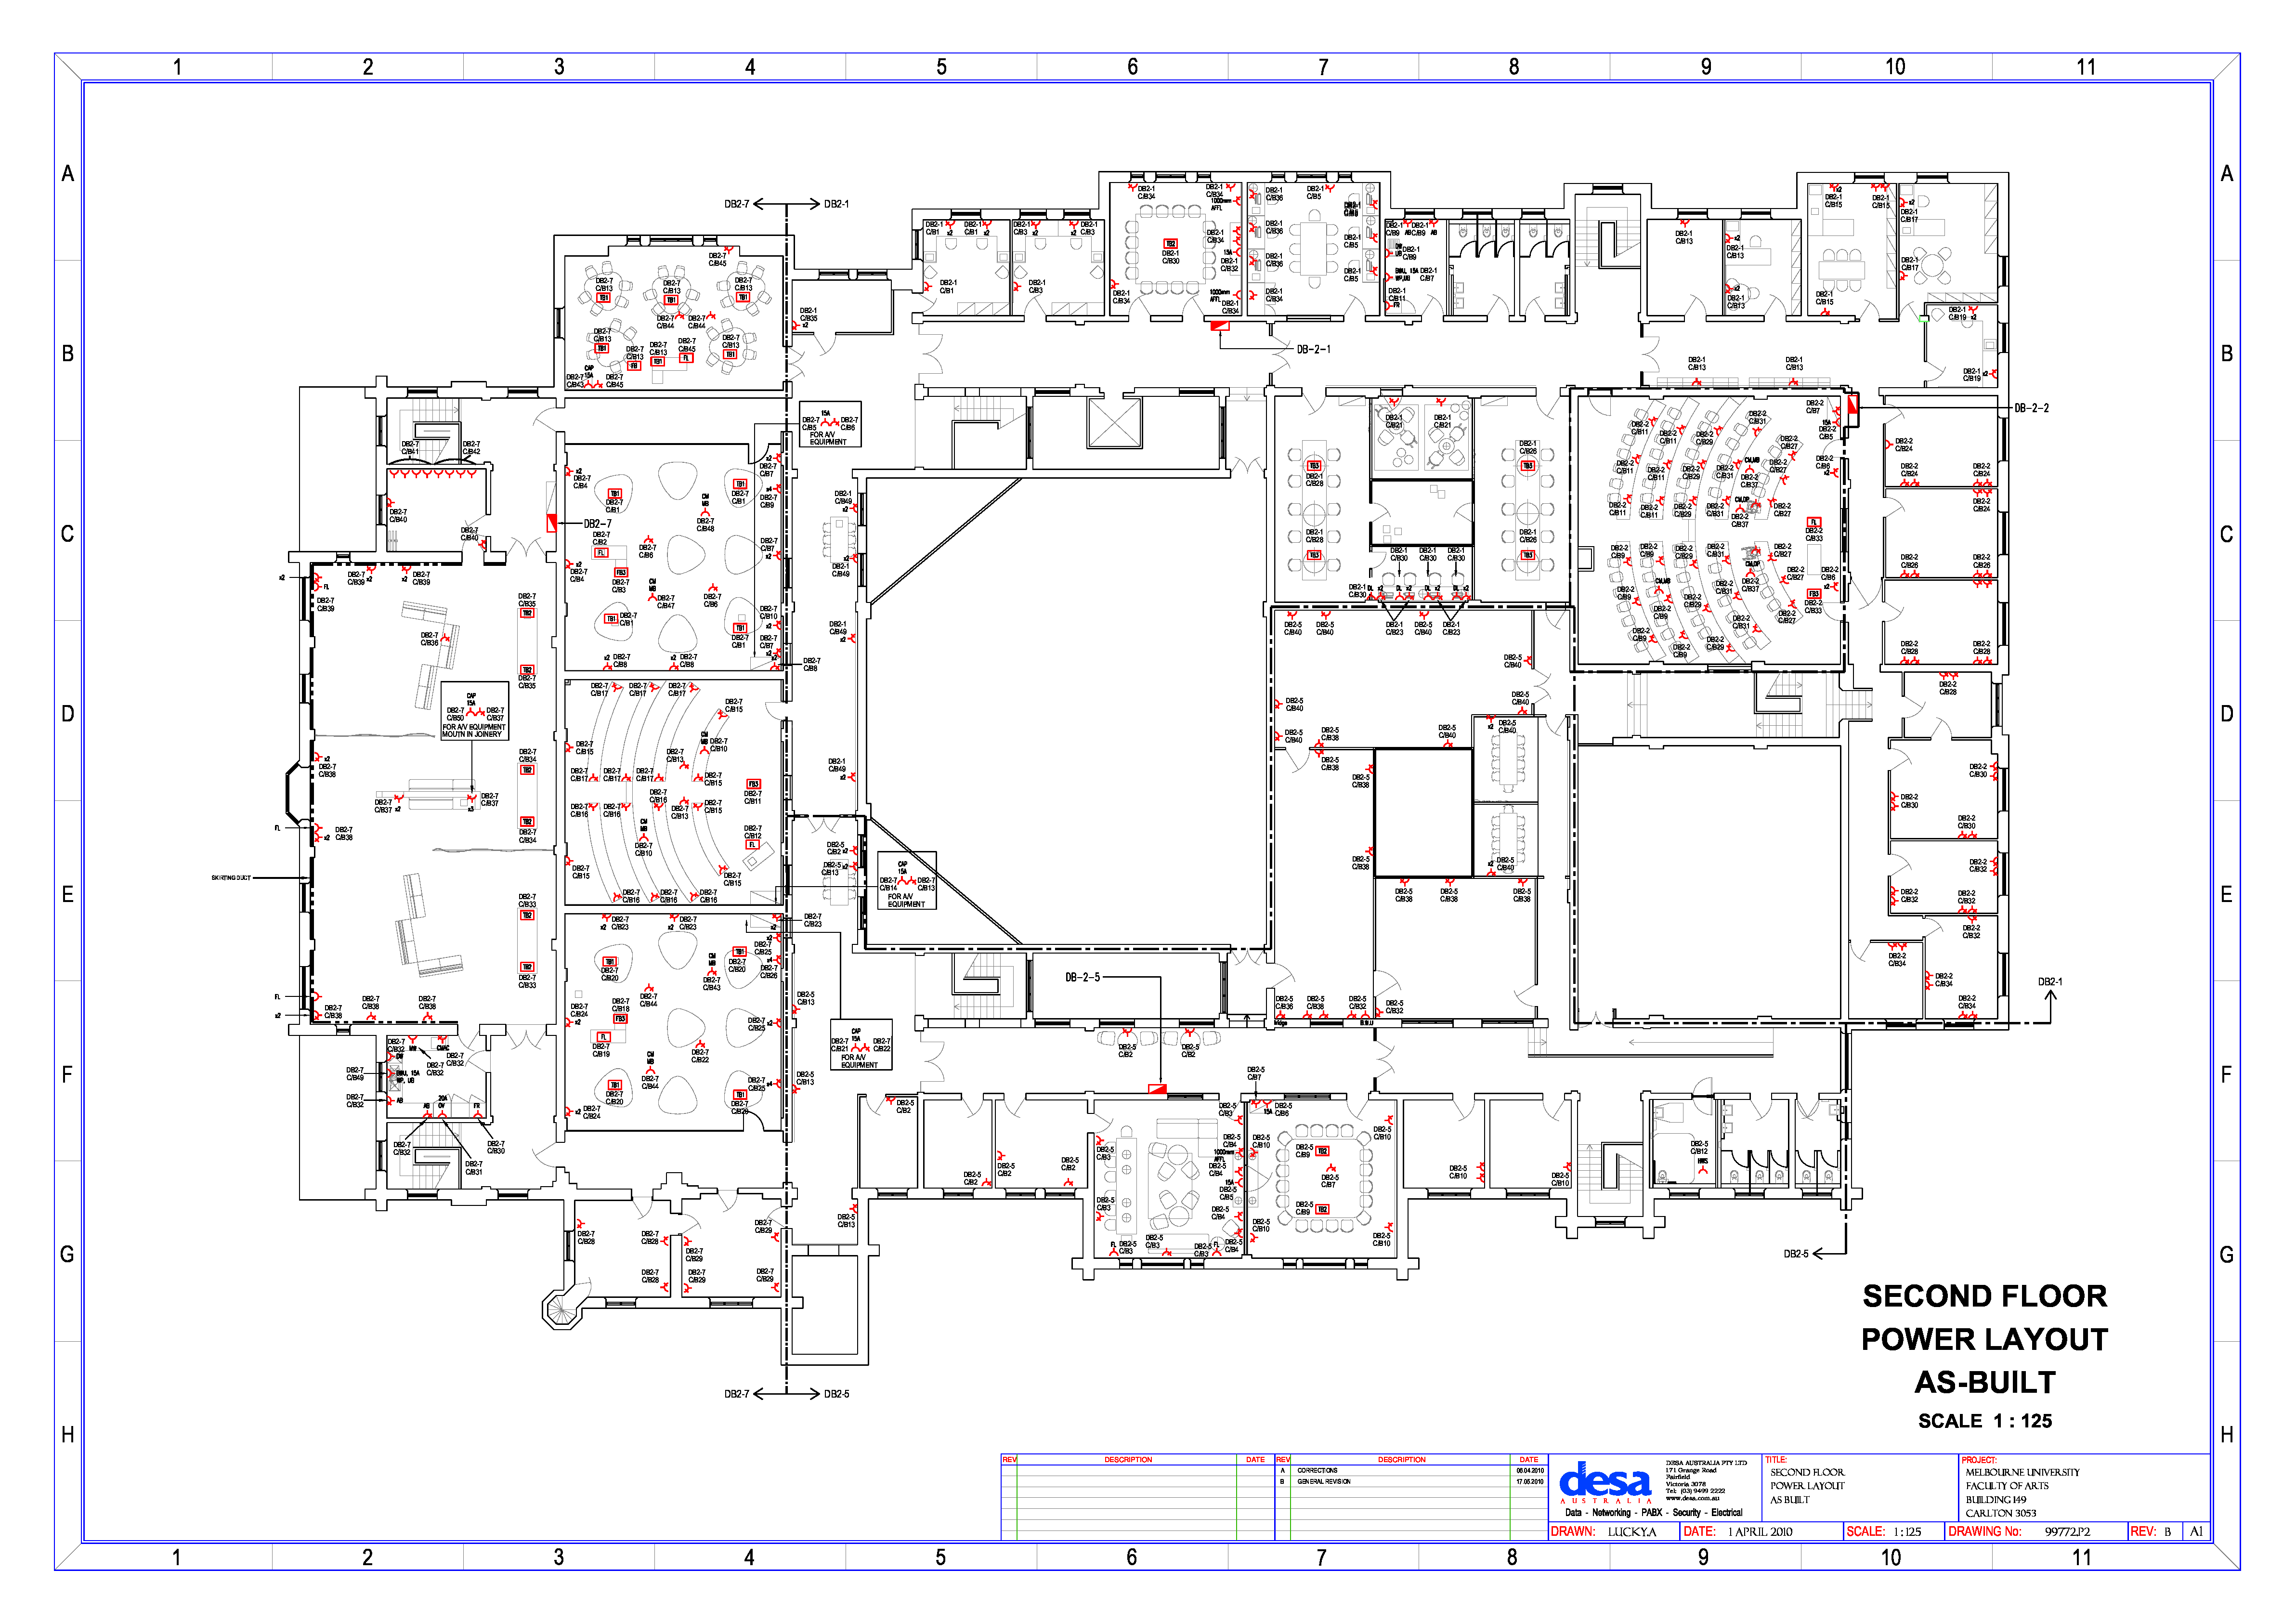

In [4]:
# Resolution = dpi (default is 72)
im = full.to_image(resolution = 144)
im.draw_line(full.curves[0], stroke = '#66FF66', stroke_width = 3)

In [5]:
# Searching for objects within an area of the pdf
# Finding an index of a specified symbol and used below
segments = {}
for i in range(0, len(full.curves)):
    curve = full.curves[i]
    if curve['y1'] > 580 and curve['y1'] < 600:
        if curve['x1'] > 400 and curve['x1'] < 500:
            segments[i] = curve

l_segs = {}
for i in range(0, len(full.lines)):
    line = full.lines[i]
    if line['y1'] > 580 and line['y1'] < 600:
        if line['x1'] > 400 and line['x1'] < 500:
            l_segs[i] = line   
print(len(l_segs))

4


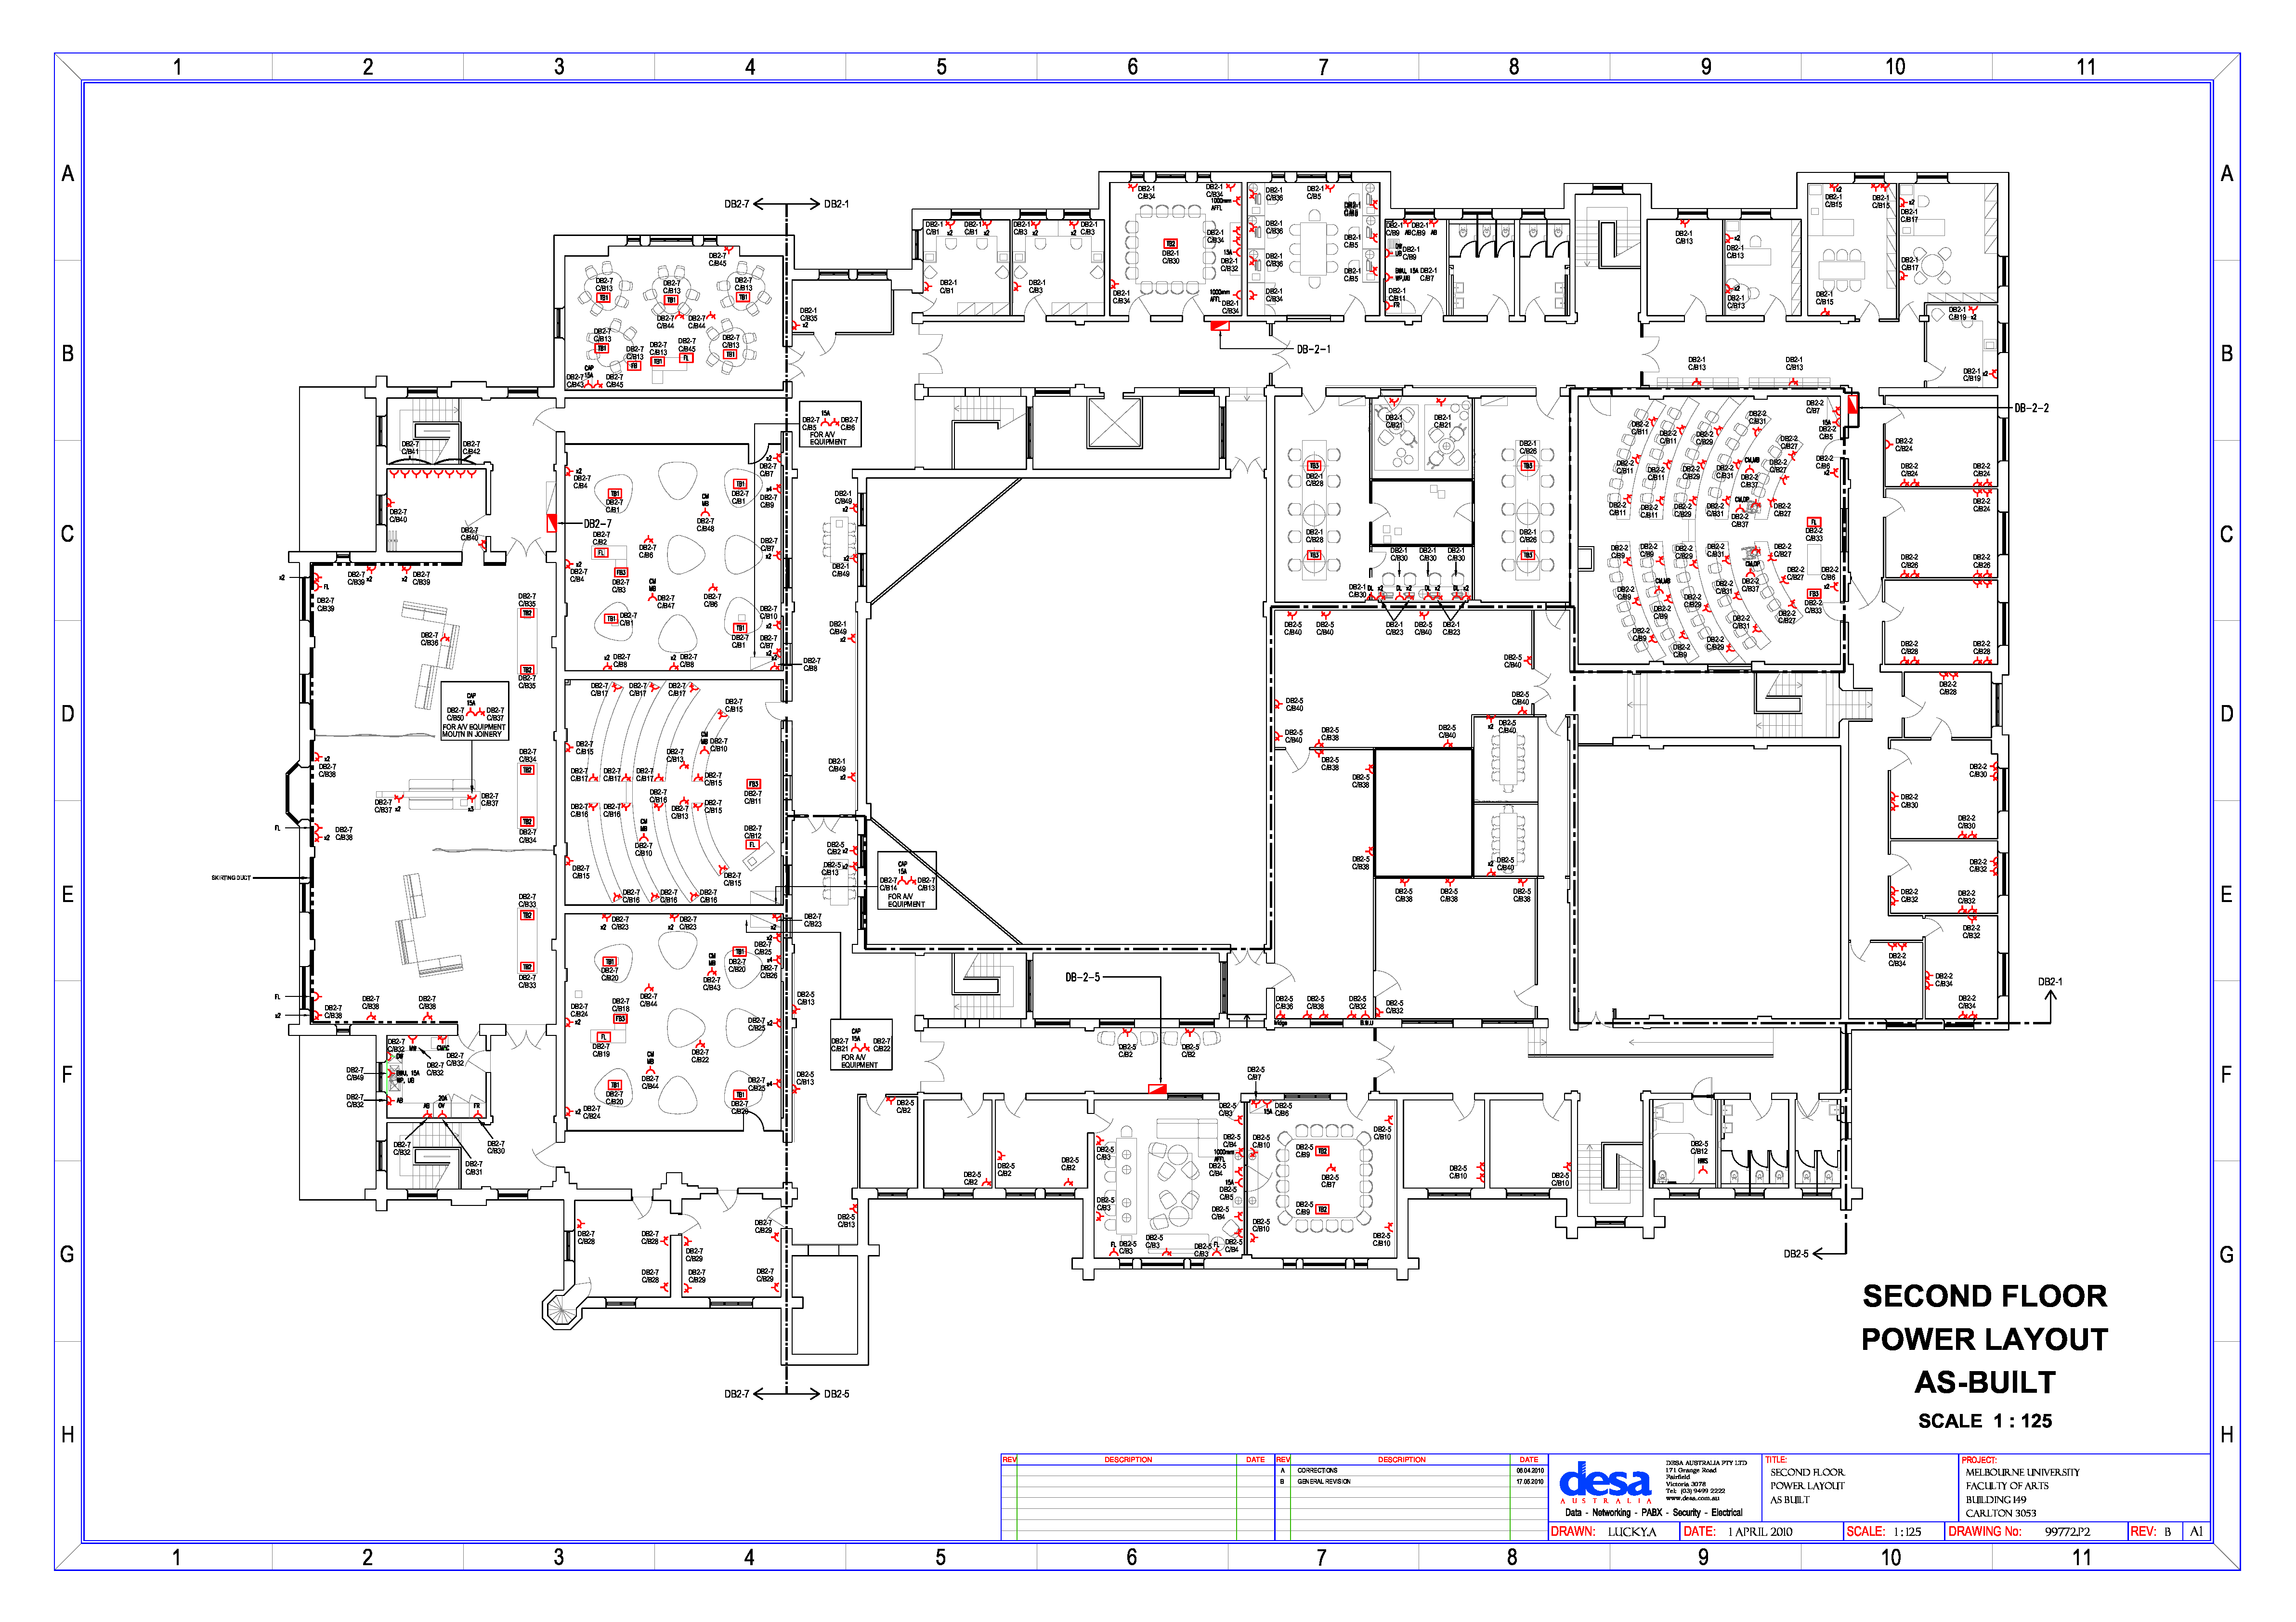

In [6]:
# Visualising the results of the matching function
im.reset()
for s in l_segs.keys():
    im.draw_line(full.lines[s], stroke = "#66FF66", stroke_width = 3)
    
im

In [7]:
segments.keys()

dict_keys([434, 5718, 7037, 7038, 7674, 7675, 7683, 7684, 7685, 7686, 7687, 7688, 8213, 8929, 8930])

In [8]:
def rotate_points(fp, idx):
    pts = fp.curves[idx]['pts']
    n_dict = {}
    
    for i in range(0, len(pts)):
        n_dict[i] = {'x': float(pts[i][0] - pts[0][0]), 'y': float(pts[i][1] - pts[0][1])}

    theta = numpy.arctan2(float(n_dict[len(n_dict)-1]['y']), float(n_dict[len(n_dict)-1]['x']))
    c, s = numpy.cos(theta), numpy.sin(theta)
    R = numpy.array(((c, -s), (s, c)))
    
    vals = {}
    for i in range(0, len(n_dict)):
        coords = numpy.round(R.dot(numpy.array([n_dict[i]['x'], n_dict[i]['y']]).reshape(2,1)), 2)
        vals[i] = numpy.round(numpy.sqrt(coords[0] **2 + coords[1] ** 2), 3)[0]
        
    return vals

In [9]:
# A symbol is being defined as the collection of distances between x/y min and max for each object that makes up the symbol
# Code defines these values and stores it as a dictionary
def create_symbol_sig(fp,idx, n_parts):
    ppoint = {}
    for i in range(0, n_parts):
        ppoint[i] = rotate_points(fp, idx + i)
    return ppoint



In [11]:
def match_symbols(fp, symbol, idx, tol):
    scores = {k : tol/(len(symbol)-1) for k in range(0, len(symbol))}
    c = 0
    while c < len(symbol) and len(fp.curves[idx + c]['pts']) == len(symbol[c]):
        test = rotate_points(fp, idx + c)
        score = 0
        for i in range(1, len(symbol[c])):
            score += (symbol[c][i] - test[i]) ** 2
        scores[c] = score
        c += 1
    
    return scores

matches = []
for i in range(0, len(full.curves)-len(sig_0)):    
    score = sum(match_symbols(full, sig_0, i, 1).values())
    if score < 1:
        matches.append(i)
        
print(len(matches))

TypeError: 'Page' object does not support indexing

In [20]:
# Visualising the results of the matching function

for i in range(0, 5):
    full = pdfplumber.open(path +fps[i]).pages[0]
    im = full.to_image(resolution = 72)
    possibles = get_matches(full)
    for p in possibles:
        for x in range(p,p+len(sig_0)):
            im.draw_line(full.curves[x]["points"], stroke='#66FF66', stroke_width=2)
    #im.save("C:/Users/User/g7/outputs/{}.png".format(i), format="png")
    im.reset()
    print("file {} saved".format(i))

file 0 saved
file 1 saved
file 2 saved
file 3 saved
file 4 saved
